# AT3 - Airfare dataset modelling for prediction - XGBoost

## 1. Loading the datasets

In [1]:
# 1.1. Launch commands to automatically reload modules
%load_ext autoreload
%autoreload 2

In [2]:
# 1.2. Import the packages and custom functions
import pandas as pd
import numpy as np
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Add the src directory to sys.path
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))

from models.sets import load_sets
from models.performance import plot_regressor_scores
from models.null import NullRegressor
from models.data_exploration import display_data_info

In [3]:
# 1.3. Load the datasets
X_train, y_train, X_val, y_val, X_test, y_test = load_sets()

## 2. Data transformation and Modelling

## 2.1 Pipelines for transformations

In [4]:
# Import packages
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


from models.sets import cyclical_transform

In [5]:
# Specify the columns for cyclical features
cyclical_cols = ['departure_month', 'departure_hour', 'departure_minute']

# Specify categorical columns
cat_cols = ['startingAirport', 'destinationAirport', 'departure_dayofweek', 'cabin_type']

In [6]:
# Define the categorical transformer
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the cyclical transformer
cyclical_transformer = Pipeline(steps=[
    ('cyclical', FunctionTransformer(cyclical_transform, validate=False))
])

In [7]:
# Define which columns to apply each transformer to
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_cols),
        ('cyclical', cyclical_transformer, cyclical_cols)
    ],
    remainder='drop' 
)

## 2.2 Modelling and evaluation

## 2.2.1 Experiment A3: Modelling

In [22]:
# Create a Pipeline called xgb_pipe that contains the preprocessor and an XGBoost regressor
xgb_pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBRegressor(
            objective='reg:squarederror',  # Specify the objective function
            random_state=42
        ))
    ]
)

In [23]:
# Fit sgd_pipe with training dataset
xgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['startingAirport',
                                                   'destinationAirport',
                                                   'departure_dayofweek',
                                                   'cabin_type']),
                                                 ('cyclical',
                                                  Pipeline(steps=[('cyclical',
                                                                   FunctionTransformer(func=<function cyclical_transform at 0x000002451C392200>))]),
                                                  ['departure_mont...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

## 2.2.2 Experiment A3: Model Evaluation

In [24]:
# Make predictions on training dataset and store the predictions in train_preds
train_preds = xgb_pipe.predict(X_train)

RMSE Training: 147.99
MAE Training: 102.21


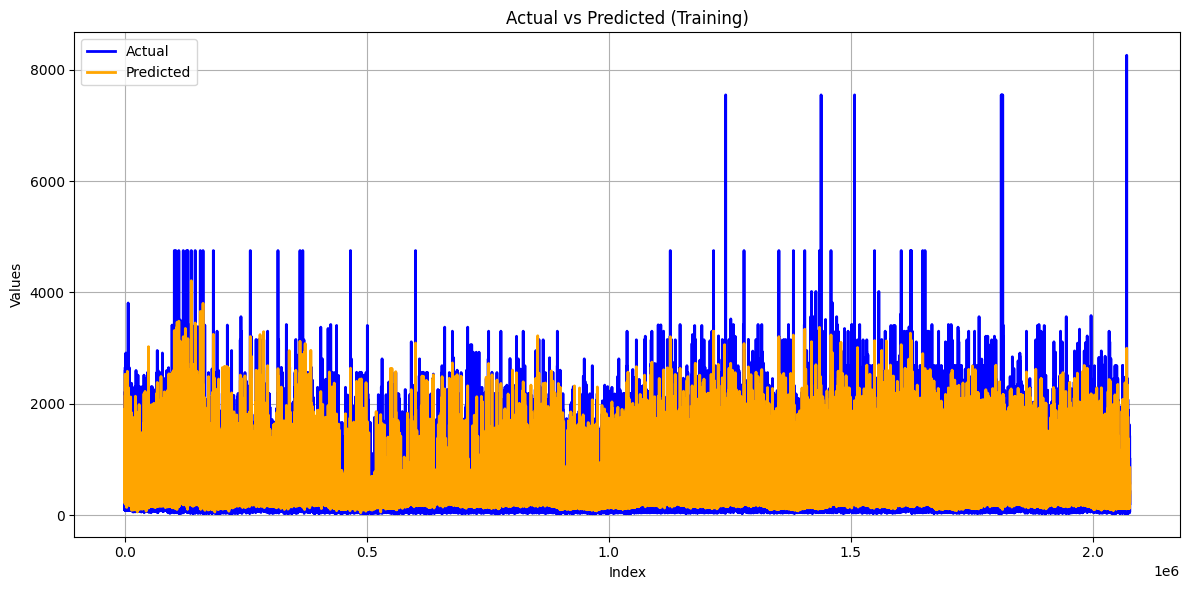

In [25]:
# Training data: Display the RMSE and MAE scores and plot the prediction of sgd model
plot_regressor_scores(y_preds=train_preds, y_actuals=y_train, set_name='Training')

RMSE Validation: 160.78
MAE Validation: 110.27


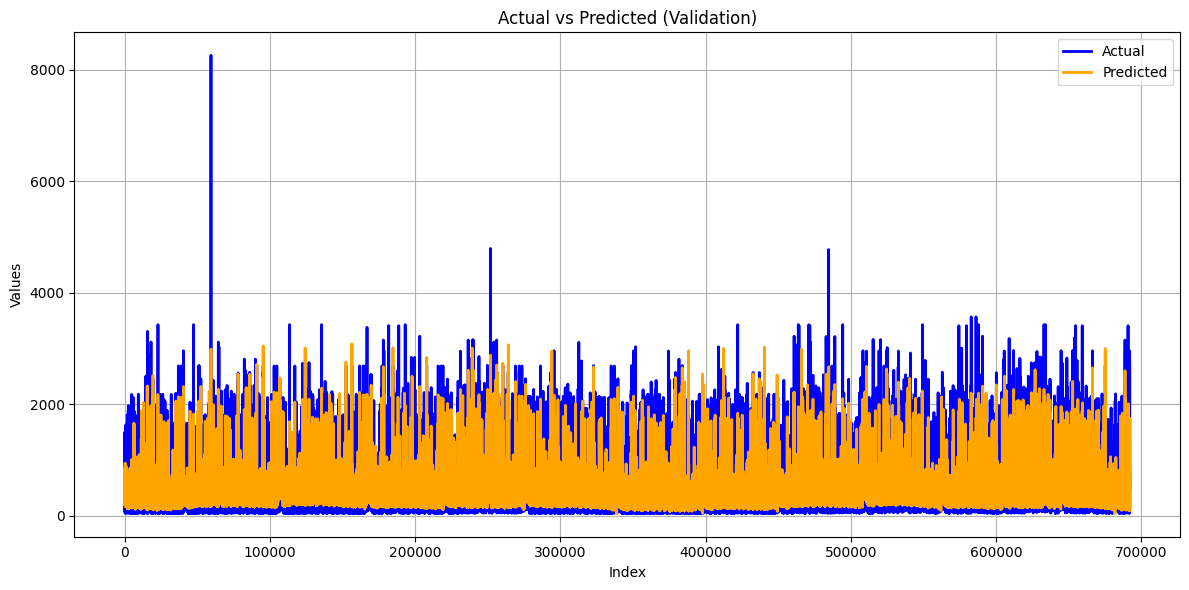

In [27]:
# Validation data: Display the RMSE and MAE scores and plot the prediction of sgd model
val_preds = xgb_pipe.predict(X_val)
plot_regressor_scores(y_preds=val_preds, y_actuals=y_val, set_name='Validation')

RMSE Test: 167.57
MAE Test: 118.81


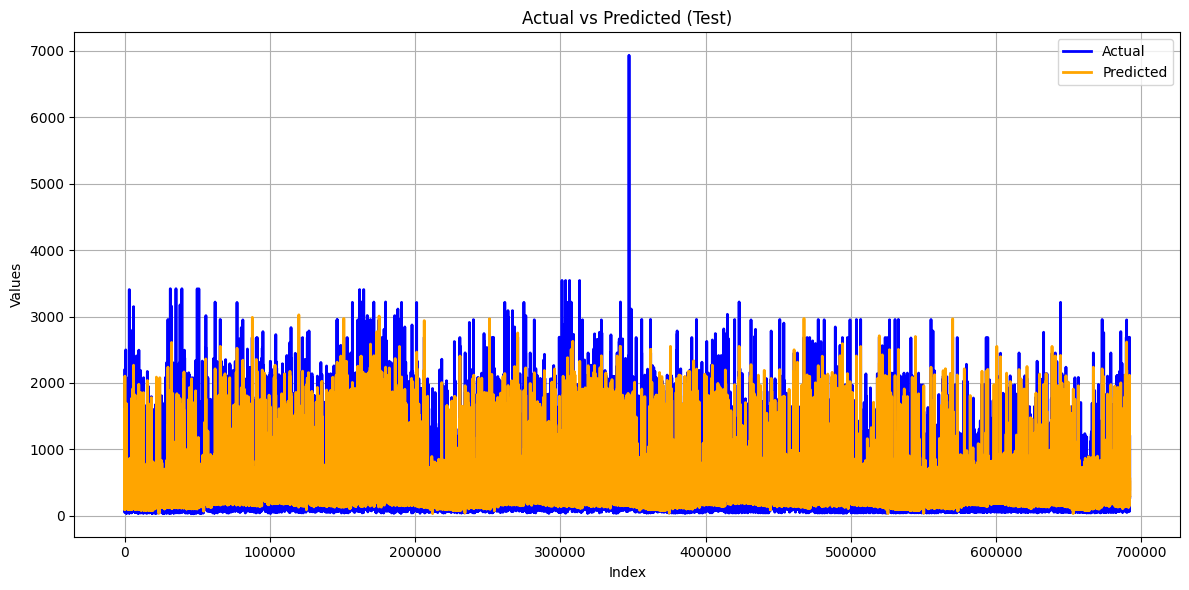

In [28]:
# Test data: Display the RMSE and MAE scores and plot the prediction of sgd model
test_preds = xgb_pipe.predict(X_test)
plot_regressor_scores(y_preds=test_preds, y_actuals=y_test, set_name='Test')

In [29]:
# Save the model 
# Import dump from joblib package and save into models folder
from joblib import dump

dump(xgb_pipe,  '../models/pine_xgb_pipeline1.joblib')

['../models/pine_xgb_pipeline1.joblib']

## 2.2.3 Experiment A4: Modelling - Using Hyperopt for Hyperparameter Tuning

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error

# Define the objective function for Hyperopt
def objective(params):
    # Create the pipeline with the current set of parameters
    xgb_pipe1 = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('xgb', XGBRegressor(
                n_estimators=int(params['n_estimators']),
                max_depth=int(params['max_depth']),
                learning_rate=params['learning_rate'],
                subsample=params['subsample'],
                colsample_bytree=params['colsample_bytree'],
                random_state=42
            ))
        ]
    )
    
    # Fit the model
    xgb_pipe1.fit(X_train, y_train)
    
    # Predict and calculate MSE
    preds = xgb_pipe1.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    
    return {'loss': mse, 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': hp.choice('n_estimators', [100, 200, 300, 400, 500]),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
}

# Trials object to track progress
trials = Trials()

# Run Hyperopt's fmin function
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Adjust as needed
    trials=trials
)

print("Best hyperparameters:", best)


100%|████████████████████████████████████████| 50/50 [29:42<00:00, 35.66s/trial, best loss: 25086.134493642217]
Best hyperparameters: {'colsample_bytree': np.float64(0.8385977926683998), 'learning_rate': np.float64(0.07237361273714017), 'max_depth': np.int64(2), 'n_estimators': np.int64(4), 'subsample': np.float64(0.9225985721539292)}


In [17]:
# Results of hyper parameter tuning is Best hyperparameters: Best hyperparameters: {'colsample_bytree': np.float64(0.8385977926683998), 
#'learning_rate': np.float64(0.07237361273714017), 
#'max_depth': np.int64(2), 'n_estimators': np.int64(4), 'subsample': np.float64(0.9225985721539292)}

# Best hyperparameters obtained from tuning
best_params = {
    'n_estimators': 4,
    'max_depth': 2,
    'learning_rate': 0.07237361273714017,
    'subsample': 0.9225985721539292,
    'colsample_bytree': 0.8385977926683998,
}

# Create a new Pipeline using the best parameters
xgb_pipe2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('xgb', XGBRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=best_params['learning_rate'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            random_state=42
        ))
    ]
)


## 2.2.4 Experiment A4: Model Evaluation

In [18]:
# Fit sgd_pipe with training dataset
xgb_pipe2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['startingAirport',
                                                   'destinationAirport',
                                                   'departure_dayofweek',
                                                   'cabin_type']),
                                                 ('cyclical',
                                                  Pipeline(steps=[('cyclical',
                                                                   FunctionTransformer(func=<function cyclical_transform at 0x000002451C392200>))]),
                                                  ['departure_mont...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.07237361273714017, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=2, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=4, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

RMSE Training: 213.70
MAE Training: 156.77


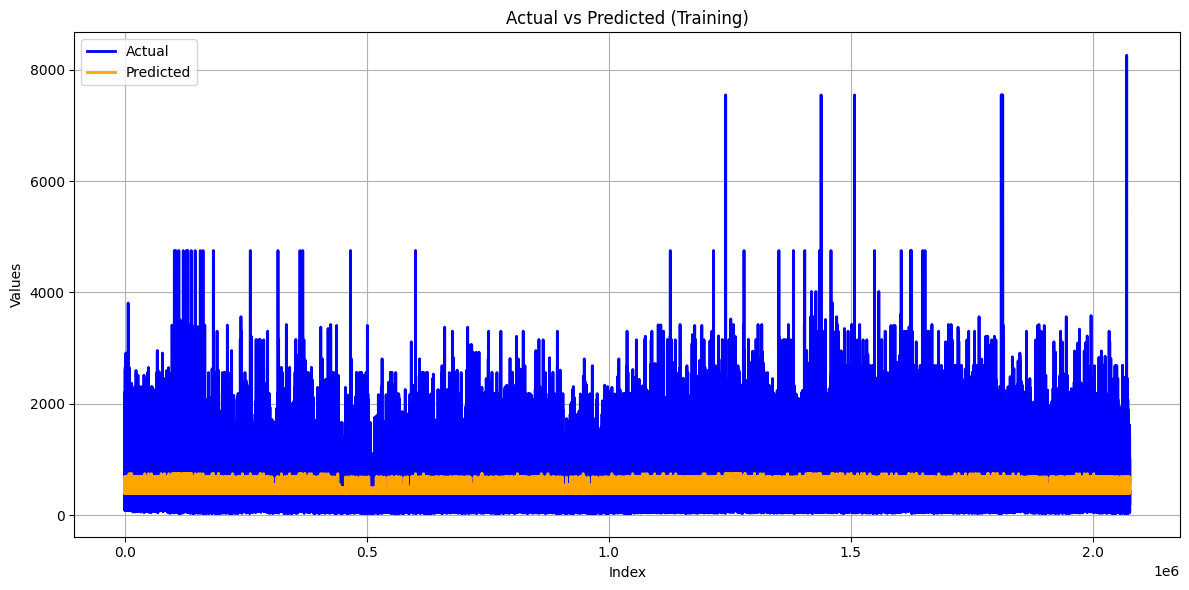

In [19]:
# Make predictions on training dataset and store the predictions in train_preds
train_preds = xgb_pipe2.predict(X_train)

# Training data: Display the RMSE and MAE scores and plot the prediction of sgd model
plot_regressor_scores(y_preds=train_preds, y_actuals=y_train, set_name='Training')

RMSE Validation: 215.55
MAE Validation: 158.65


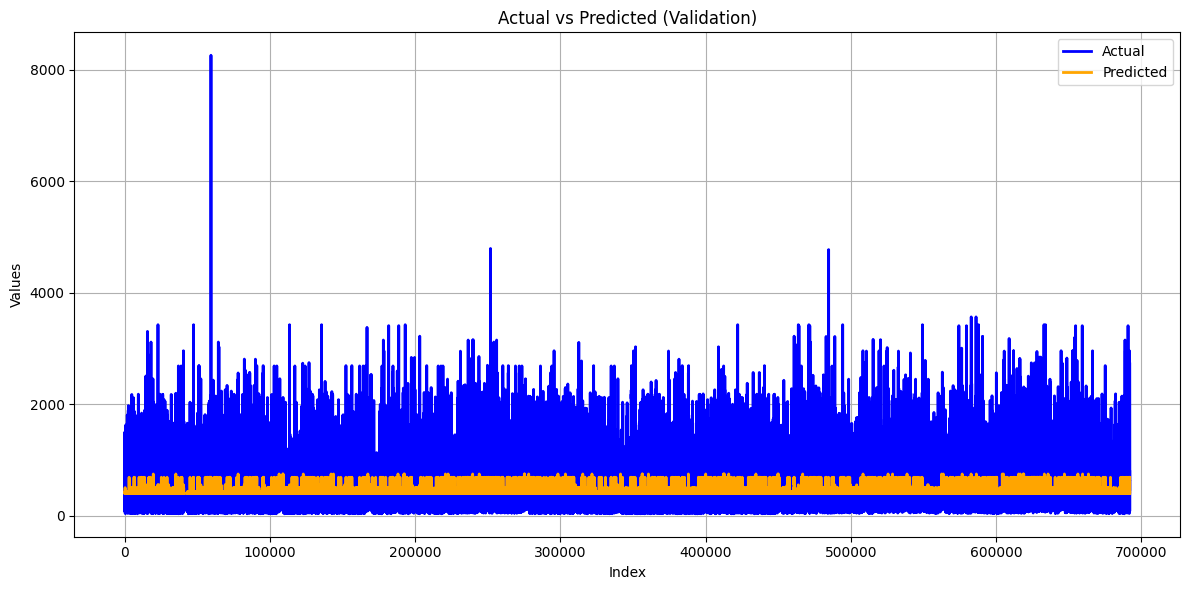

In [21]:
# Validation data: Display the RMSE and MAE scores and plot the prediction of sgd model
val_preds = xgb_pipe2.predict(X_val)
plot_regressor_scores(y_preds=val_preds, y_actuals=y_val, set_name='Validation')